【第三周作业】

尝试修改nlpdemo，做一个多分类任务，判断特定字符在字符串的第几个位置，使用rnn和交叉熵。

In [1]:
#coding:utf8

import torch
import torch.nn as nn
import numpy as np
import random
import json
import matplotlib.pyplot as plt

In [2]:
class TorchModel(nn.Module):
    def __init__(self, vector_dim, sentence_length, vocab):
        super(TorchModel, self).__init__()
        self.embedding = nn.Embedding(len(vocab), vector_dim, padding_idx=0)  #embedding层
        self.layer = nn.RNN(input_size=20, hidden_size=8, bias=False, batch_first=True)
        self.loss =  nn.CrossEntropyLoss()  

    #当输入真实标签，返回loss值；无真实标签，返回预测值
    def forward(self, x, y=None):
        x = self.embedding(x)                      #(batch_size, sen_len) -> (batch_size, sen_len, vector_dim)
        y_pred,h = self.layer(x)
        h = h.squeeze()
        if y is not None:
            return self.loss(h, y)   #预测值和真实值计算损失
        else:
            return h                 #输出预测结果                #输出预测结果

In [3]:
def build_vocab():
    chars = "你我他defghijklmnopqrstuvwxyz"  #字符集
    vocab = {"pad":0}
    for index, char in enumerate(chars):
        vocab[char] = index+1   #每个字对应一个序号
    vocab['unk'] = len(vocab) #26
    return vocab

In [4]:
#随机生成一个样本
#从所有字中选取sentence_length个字
#反之为负样本
def build_sample(vocab, sentence_length):
    #随机从字表选取sentence_length个字，可能重复
    x = [random.choice(list(vocab.keys())) for _ in range(sentence_length)]
    y = 0

    random_num=[i for i in range(2)]
    p=random.choice(random_num)
    if p!=0:
        x[random.choice([i for i in range(6)])]='你'
    for string in x:
        i = 0
        for string in x:
            if string == '你':
                break
            else:
                i += 1
        y = i
    #print(x)
    #指定哪些字出现时为正样本
    #print(y)
    x = [vocab.get(word, vocab['unk']) for word in x]   #将字转换成序号，为了做embedding
    return x , y

In [5]:
#建立数据集
#输入需要的样本数量。需要多少生成多少
def build_dataset(sample_length, vocab, sentence_length):
    dataset_x = []
    dataset_y = []
    for i in range(sample_length):
        x, y = build_sample(vocab, sentence_length)
        dataset_x.append(x)
        dataset_y.append(y)
    return torch.LongTensor(dataset_x), torch.LongTensor(dataset_y)

In [6]:
#建立模型
def build_model(vocab, char_dim, sentence_length):
    model = TorchModel(char_dim, sentence_length, vocab)
    return model

In [7]:
#测试代码
#用来测试每轮模型的准确率
def evaluate(model, vocab, sample_length):
    model.eval()
    x, y = build_dataset(200, vocab, sample_length)   #建立200个用于测试的样本
    correct, wrong = 0, 0
    with torch.no_grad():
        # print(x)
        y_pred = model(x)      #模型预测
        # print(y_pred)
        for y_p, y_t in zip(y_pred, y):  #与真实标签进行对比
            y_ft = y_p.argmax()
            if int(y_ft) ==int(y_t):
                correct += 1  # 负样本判断正确
            else:
                wrong += 1
    print("正确预测个数：%d, 正确率：%f"%(correct, correct/(correct+wrong)))
    return correct/(correct+wrong)

In [8]:
def main():
    #配置参数
    epoch_num = 200        #训练轮数
    batch_size = 20       #每次训练样本个数
    train_sample = 1000    #每轮训练总共训练的样本总数
    char_dim = 20         #每个字的维度
    sentence_length = 6   #样本文本长度
    learning_rate = 0.002 #学习率
    # 建立字表
    vocab = build_vocab()
    # 建立模型
    model = build_model(vocab, char_dim, sentence_length)
    # 选择优化器
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    log = []
    # 训练过程
    for epoch in range(epoch_num):
        model.train()
        watch_loss = []
        for batch in range(int(train_sample / batch_size)):
            x, y = build_dataset(batch_size, vocab, sentence_length) #构造一组训练样本
            optim.zero_grad()    #*梯度归零
            loss = model.forward(x, y)  # 计算loss
            loss.backward()      #计算梯度
            optim.step()         #*更新权重
            watch_loss.append(loss.item())
        print("=========\n第%d轮平均loss:%f" % (epoch + 1, np.mean(watch_loss)))
        acc = evaluate(model, vocab, sentence_length)   #测试本轮模型结果
        log.append([acc, np.mean(watch_loss)])
    #画图
    plt.plot(range(len(log)), [l[0] for l in log], label="acc")  #画acc曲线
    plt.plot(range(len(log)), [l[1] for l in log], label="loss")  #画loss曲线
    plt.legend()
    plt.show()
    #保存模型
    torch.save(model.state_dict(), "rnnmodel.pth")
    # 保存词表
    writer = open("vocab.json", "w", encoding="utf8")
    writer.write(json.dumps(vocab, ensure_ascii=False, indent=2))
    writer.close()
    return

In [9]:
#使用训练好的模型做预测
def predict(model_path, vocab_path, input_strings):
    char_dim = 20  # 每个字的维度
    sentence_length = 6  # 样本文本长度
    input_size=sentence_length
    hidden_size=8
    vocab = json.load(open(vocab_path, "r", encoding="utf8")) #加载字符表
    model = build_model(vocab, char_dim, sentence_length)    #建立模型
    model.load_state_dict(torch.load(model_path))             #加载训练好的权重
    x = []
    for input_string in input_strings:
        x.append([vocab[char] for char in input_string])  #将输入序列化
    model.eval()   #测试模式
    with torch.no_grad():  #不计算梯度
        result = model.forward(torch.LongTensor(x))  #模型预测
        print(result)
        print("特定字符：你 在字符串的位置",torch.max(result,1).indices+1)


第1轮平均loss:2.185191
正确预测个数：35, 正确率：0.175000
第2轮平均loss:2.057810
正确预测个数：36, 正确率：0.180000
第3轮平均loss:1.907021
正确预测个数：60, 正确率：0.300000
第4轮平均loss:1.761751
正确预测个数：79, 正确率：0.395000
第5轮平均loss:1.636108
正确预测个数：91, 正确率：0.455000
第6轮平均loss:1.513152
正确预测个数：123, 正确率：0.615000
第7轮平均loss:1.433372
正确预测个数：131, 正确率：0.655000
第8轮平均loss:1.261606
正确预测个数：137, 正确率：0.685000
第9轮平均loss:1.176934
正确预测个数：148, 正确率：0.740000
第10轮平均loss:1.067295
正确预测个数：154, 正确率：0.770000
第11轮平均loss:1.030226
正确预测个数：147, 正确率：0.735000
第12轮平均loss:0.986561
正确预测个数：151, 正确率：0.755000
第13轮平均loss:0.997366
正确预测个数：143, 正确率：0.715000
第14轮平均loss:0.969879
正确预测个数：159, 正确率：0.795000
第15轮平均loss:0.937403
正确预测个数：168, 正确率：0.840000
第16轮平均loss:0.938770
正确预测个数：165, 正确率：0.825000
第17轮平均loss:0.917236
正确预测个数：174, 正确率：0.870000
第18轮平均loss:0.903991
正确预测个数：177, 正确率：0.885000
第19轮平均loss:0.875774
正确预测个数：176, 正确率：0.880000
第20轮平均loss:0.851250
正确预测个数：166, 正确率：0.830000
第21轮平均loss:0.833645
正确预测个数：178, 正确率：0.890000
第22轮平均loss:0.832617
正确预测个数：174, 正确率：0.870000
第23轮平均loss:0.817119
正确预测

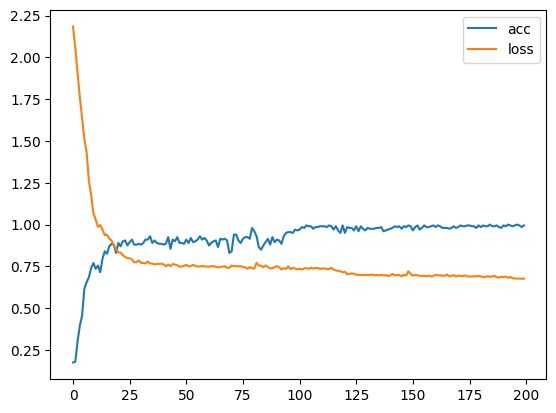

tensor([[-0.9999, -0.9995, -0.9996, -0.9979, -0.9999, -0.9948,  0.9999, -0.9996],
        [-0.9999, -0.9904,  0.9993, -0.9907, -0.9985, -0.9999, -0.9991, -0.9990],
        [-0.9999, -0.9994, -0.9996, -0.9977, -0.9999, -0.9965,  0.9999, -0.9993],
        [-0.9999, -0.9992, -0.9998, -0.9982, -0.9999, -0.9988,  0.9999, -0.9994]])
特定字符：你 在字符串的位置 tensor([7, 3, 7, 7])


In [10]:
if __name__ == "__main__":
    main()
    test_strings = ["fnvfee", "wz你dfg", "rqwdeg", "n我kwww"]
    predict("rnnmodel.pth", "vocab.json", test_strings)